In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()
sns.set_style("white")

%matplotlib inline


## Original Organics formulation

In [2]:
Wzx = np.matrix('-0.5, 0, 0, 0; \
                -0.3536 -0.3536 0 0; \
                0 0.5 0 0; \
                0.3536 0.3536 0 0;\
                0.5 0 0 0;\
                0.3536 -0.3536 0 0;\
                0 -0.5 0 0; \
                -0.3536 -0.3536 0 0')

Wax = np.matrix('0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1')

Wbx = np.matrix('0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0')

num = np.cos(np.pi / 4)
Wyy = 0.25 * np.matrix([[1, num, 0, -num, -1, -num, 0, num],
                [num, 1, num, 0, -num, -1, -num, 0],
                [0, num, 1, num, 0, -num, -1, -num],
                [-num, 0, num, 1, num, 0, -num, -1],
                [-1, -num, 0, num, 1, num, 0, -num],
                [-num, -1, -num, 0, num, 1, num, 0],
                [0, -num, -1, -num, 0, num, 1, num],
                [num, 0, -num, -1, -num, 0, num, 1]])



Way = 0
Wby = 0
cz = 0
ca = 0
cb = 0
cy = 0

# Time constants in ms
ta = 10 
tb = 10
ty = 10
dt = 10

In [3]:
U,V = np.linalg.eig(Wyy)

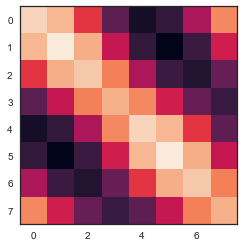

In [4]:
A = V * np.diag(U) * V.T
plt.imshow(A)
plt.show()

In [5]:
posx = [0.0] * 25 + [0.2] * 75 + [0.0] * 300
posy = [0.0] * 25 + [-0.5] * 75 + [0.0] * 300
begin = [1.0] * 75 + [0.0] * 325
delay = [0.0] * 300 + [1.0] * 25 + [0.0] * 75

x_mat = np.matrix([posx, posy, begin, delay])


In [6]:
y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(200):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

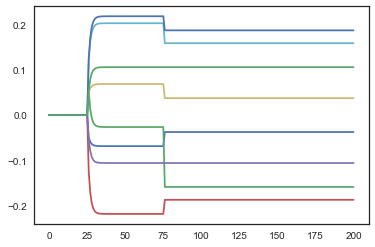

In [7]:
# Plot of Y traces!
plt.figure()
plt.plot(Ymat.T);

## Trying to have Organics maintain a state

Holding can be achieved by setting `Wyy = 1` (identity matrix)

In [8]:
Wyy = 1

y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(400):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

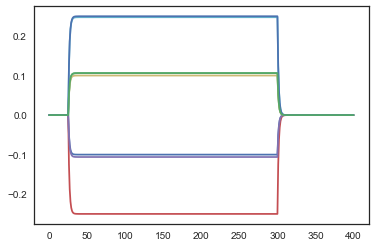

In [9]:
plt.plot(Ymat.T);

## Gating of two-neuron module

In [10]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def start_simulation(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    
    
    # Unpack variables
    I, u, v, y, sig = state_init
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u )) / tau * dt

        y += (-y + u - v) / 100 * dt

        v_lst.append(v)
        u_lst.append(u)
        y_lst.append(y)
        I_lst.append(I)
        sig_lst.append(sig)
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

### Updates from previous meeting

Changes from the previous meeting:

1. Moved threshold y0 to a z-neuron with $z = y - y_0$

2. Removed $I_{ref}$. Previous equation

3. 'Reseting' is implemented by an impulse given to $v$ at the start of the trial



### Description of the current model

At a high level, the simulation alternates between two states which is encoded by a variable `s`. In the setup, `u` and `v` are two neurons that mutually inhibit each other according to this dynamics:

$$ \tau\frac{du}{dt} = -u + \theta \ (W_{uI}I - W_{uv}v)$$

Similarly for $v$,

$$ \tau\frac{dv}{dt} = -v + \theta \ (W_{vI}I - W_{vu}u + I_p)$$

$y$ and $z$ are read-out neurons. $y$ measures the difference between $u$ and $v$ and $z$ measures the deviation of $y$ from the threshold $y_0$.

$$ \tau\frac{dy}{dt} = -y + u - v $$

and for $z$,

$$ \tau\frac{dz}{dt} = -z + y - y_0$$

The global state is given by $s$ which is an external signal. This state alternates between two modes:

* When $s = 0$, the network operates in *integration* mode
    - $v$ receives an impulse $I_p = 5$, for a duration of two time steps. After that $I_p = 0$.
    - $I$ remains constant (gated out, uncoupled from $z$)


* When $s = 1$, the network operates in *update* mode
    - $I_p$ continues to be 0.
    - $I$ gets coupled to $z$.
    
    In particular, $ \tau\frac{dI}{dt} = K(y-y_0)  $


The behavior of $I$ is different in these two different modes. To achieve this, we rely on the gating variables $a_I$, and require that

$$ \tau\frac{dI}{dt} = a_IK(y - y_0) $$


The gating $a_I$ itself can be modeled as a dynamic variable that is linked to the global state $s$.
$$ \frac{da_I}{dt} = \frac{1}{\tau_I}(-a_I + s) $$

The simulation is run below, each state lasts 100 ms.

In [11]:
def plot_simulation(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst, alpha=0.1)
    ax[0].fill_between(np.arange(nsteps) * dt, min(ulst), max(ulst), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst, alpha=0.1)
    ax[1].fill_between(np.arange(nsteps) * dt, min(vlst), max(vlst), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst, alpha=0.1)
    ax[2].fill_between(np.arange(nsteps) * dt, min(ylst), max(ylst), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst, alpha=0.1)
    ax[3].fill_between(np.arange(nsteps) * dt, min(Ilst), max(Ilst), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [12]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 5.0,
              'sigma': 0.0}

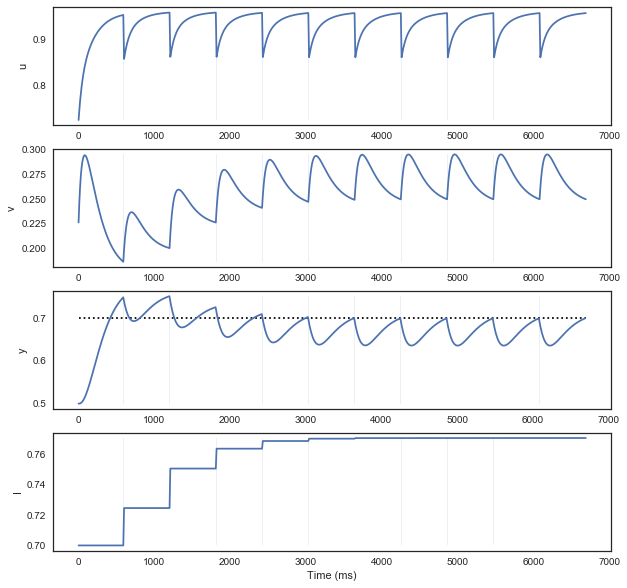

In [13]:
# Initial run
state_init = [0.7, 0.7, 0.2, 0.5, 0.0]
ulst, vlst, ylst, Ilst, siglst = start_simulation(state_init, PARAMS_DICT, 60)

# For subsequent runs, flip the state every 100 trials
for k in range(20):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 60)
    else:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation(state_init, PARAMS_DICT, 1)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    Ilst += Ilst2
    siglst += siglst2
plot_simulation(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

## Adding noise to the simulation

Now we try to do the simulation in parallel, with multiple trials and noise

In [14]:
def start_simulation_parallel(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

In [15]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

In [16]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05}

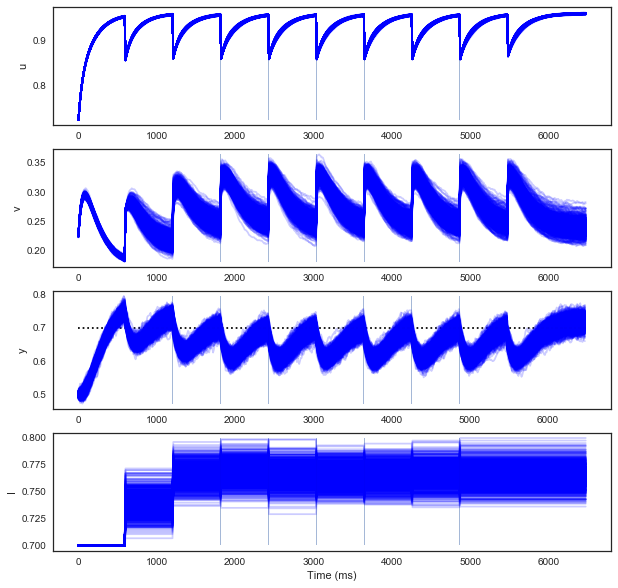

In [17]:
# Initial run
ntrials = 1000
duration = 600 #ms
nstages = 10
nbin = int(duration / PARAMS_DICT['dt'])


state_init = [np.ones(ntrials) * 0.7, 
              np.ones(ntrials) * 0.7, 
              np.ones(ntrials) * 0.2,
              np.ones(ntrials) * 0.5,
              0.0]

ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)

# For subsequent runs, flip the state every 100 trials
for k in range((nstages - 2) * 2):
    #acoefs = 1 - acoefs
    state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
    if state_init[4] == 0.0:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2
    Ilst += Ilst2
    siglst += siglst2
    
# For the last run, produce the behavior when the threshold is reached
ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 100)

ulst += ulst2
vlst += vlst2
ylst += ylst2
Ilst += Ilst2
siglst += siglst2

plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Mean level at decision time is  0.6905821887265251
Mean decision time is  73.264


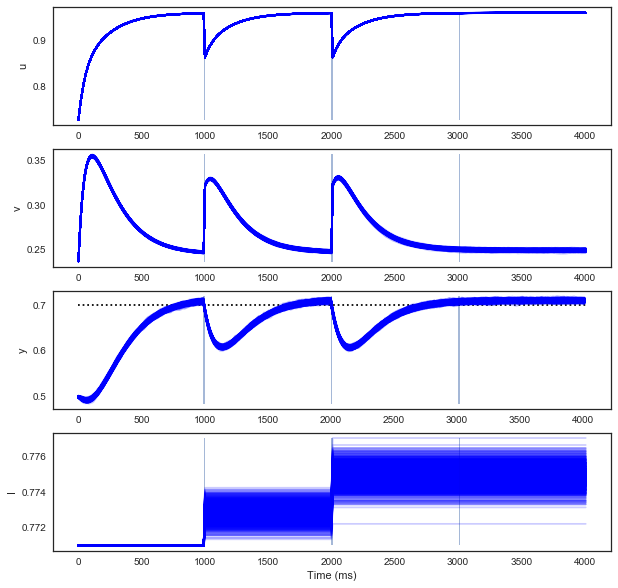

In [18]:
# Functions for using in a for loop
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 200)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

#ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(nstages=3, sigma=sigma, K=K, initI=0.766)
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=1000, sigma=0.01, K=2, initI=0.771)
plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, PARAMS_DICT)

Ylst2 = np.array(ylst2)
times = get_times_lst_from_y(np.array(Ylst2), 0.7)
times = times[(times > 0) & (times != np.inf)]
print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
print('Mean decision time is ', np.mean(times))

In [19]:
# initI = 0.766 for correct time in 600 ms

In [20]:
Klst = np.linspace(0, 4, 20)
sigma_lst = np.linspace(0.002, 0.04, 5)

meanlst = np.zeros((len(sigma_lst), len(Klst)))
varlst = np.zeros((len(sigma_lst), len(Klst)))

for i in range(len(sigma_lst)):
    for j in range(len(Klst)):
        sigma = sigma_lst[i]
        K = Klst[j]
        #print('Working on K = ', K)
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, sigma=sigma, K=K, initI=0.771)
        times = get_times_lst_from_y(np.array(ylst2), 0.7)
        times_filt = times[(times > 0) & (times != np.inf)]
        
        if len(times_filt) < len(times):
            print('inf encountered')
            meanlst[i][j] = np.NAN
            varlst[i][j] = np.NAN
        else:
            meanlst[i][j] = np.mean(times)
            varlst[i][j] = np.std(times)

Text(0,0.5,'$\\sigma$')

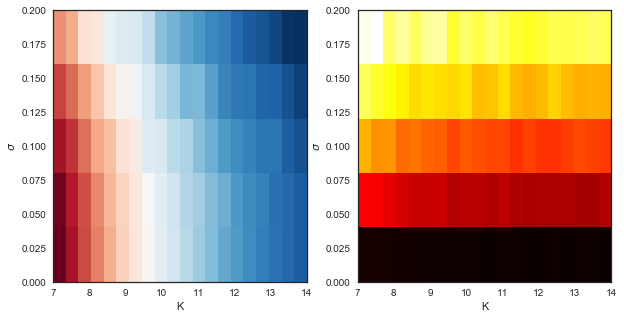

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.flipud((meanlst - 60)), cmap='RdBu_r', extent=[7, 14, 0, 0.2], aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(varlst), extent=[7, 14, 0, 0.2], cmap='hot', aspect='auto')
plt.xlabel('K')
plt.ylabel(r'$\sigma$')

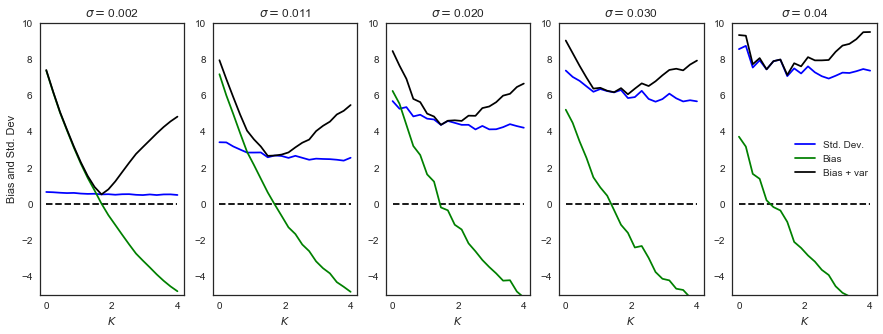

In [22]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    sq_bias = (meanlst[i]-400)**2
    biasid = np.argmin(sq_bias)
    varid = np.argmin(varlst[i])
    ax[i].plot(Klst, varlst[i], color='b', label='Std. Dev.')
    ax[i].plot(Klst, meanlst[i] - 60, color='g', label='Bias')
    ax[i].plot(Klst, np.sqrt((meanlst[i] - 60) ** 2 + varlst[i]**2), color='k', label='Bias + var')
    ax[i].set_ylim((-5, 10))
    ax[i].set_xlabel(r'$K$')
    ax[i].set_title(r'$\sigma=$' + str(sigma_lst[i])[:5])
    ax[i].hlines(0, min(Klst), max(Klst), linestyles='--')
    #ax[i-1].axvline(x=Klst[biasid], linestyle='--', color='g')
    #ax[i-1].axvline(x=Klst[varid], linestyle='--', color='b')

ax[0].set_ylabel('Bias and Std. Dev')
ax[4].legend(loc='right');
#save_safe('bias_variance_sigma_sigma.pdf')

In [23]:
mselst = (meanlst - 60) ** 2 + varlst ** 2
mselst[np.isnan(mselst)] = np.inf
np.argmin(mselst, axis=1)

# TODO: simulate multiple times and take the average

array([8, 7, 7, 9, 7], dtype=int64)

### Ready, Set, Go task

To simulate the Ready, Set, Go task, we first pick a parameter (arbitrarily within the set of parameters simulated above. We will pick $\sigma = 0.01, I_{init} = 0.77$.

From the graph above, the optimal value of $K$ for these parameters is $K \approx 1.9$. We can now simulate the RSG task below.

Doing time # 0 = 500.0
Doing time # 1 = 520.0
Doing time # 2 = 540.0
Doing time # 3 = 560.0
Doing time # 4 = 580.0
Doing time # 5 = 600.0
Doing time # 6 = 620.0
Doing time # 7 = 640.0
Doing time # 8 = 660.0
Doing time # 9 = 680.0
Doing time # 10 = 700.0


Text(0.5,1,'Production times in RSG simulation')

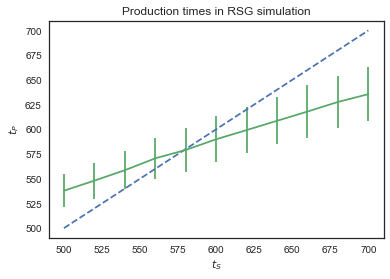

In [24]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(500, 700, 11)

prod_time_lst = []
prod_var_lst = []

for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, 
                                                           duration=time, sigma=0.01, K=1.8, initI=0.77)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('Production times in RSG simulation')

Doing time # 0 = 100.0
Doing time # 1 = 220.0
Doing time # 2 = 340.0
Doing time # 3 = 460.0
Doing time # 4 = 580.0
Doing time # 5 = 700.0
Doing time # 6 = 820.0
Doing time # 7 = 940.0
Doing time # 8 = 1060.0
Doing time # 9 = 1180.0
Doing time # 10 = 1300.0


Text(0.5,1,'Production times in RSG simulation')

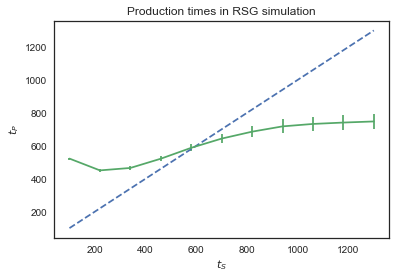

In [25]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
durations = np.linspace(100, 1300, 11)

prod_time_lst = []
prod_var_lst = []

for i, time in enumerate(durations):
    print('Doing time #', i, '=', time)
    
    ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=time, sigma=0.01, K=1.8, initI=0.771)

    Ylst2 = np.array(ylst2)
    times = get_times_lst_from_y(np.array(Ylst2), 0.7)
    times = times[(times > 0) & (times != np.inf)]
    #print('Mean level at decision time is ', np.mean(Ylst2[60,:]))
    #print('Mean decision time is ', np.mean(times))
    prod_time_lst.append(np.mean(times))
    prod_var_lst.append(np.std(times))
    
# Plot the result, error bars represent standard deviation
plt.plot(durations, durations, '--')
plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)
plt.xlabel('$t_S$')
plt.ylabel('$t_P$')
plt.title('Production times in RSG simulation')

### Scalar variability

In [26]:
# Initiate the trial with a fixed current, trial duration is randomized in [400, 600]
sigmas = np.linspace(0.01, 0.2, 6)
durations = np.linspace(400, 1000, 10)

prod_time_lst = np.zeros((6, 10))
prod_var_lst = np.zeros((6, 10))

for i, sigma in enumerate(sigmas):
    print('Doing sigma #', i, '=', sigma)
    for j, duration in enumerate(durations):
        ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial(ntrials=1000, nstages=3, duration=duration, sigma=sigma, K=1.89, initI=0.771)

        Ylst2 = np.array(ylst2)
        times = get_times_lst_from_y(np.array(Ylst2), 0.7)
        times = times[(times > 0) & (times != np.inf)]

        prod_time_lst[i][j] = np.mean(times)
        prod_var_lst[i][j] = np.std(times)
    

Doing sigma # 0 = 0.01
Doing sigma # 1 = 0.048
Doing sigma # 2 = 0.086
Doing sigma # 3 = 0.12399999999999999
Doing sigma # 4 = 0.162
Doing sigma # 5 = 0.2


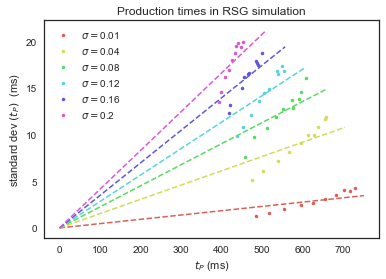

In [27]:
colors = sns.color_palette('hls', 6)

# Plot the result
for i in range(6):
    meanlst = prod_time_lst[i,:] * 10
    varlst = prod_var_lst[i,:]

    meanmean = np.mean(meanlst)
    varmean = np.mean(varlst)
    
    plotx = np.linspace(0, meanmean * 1.2, 10)

    # Do linear regression
    m, c,_,_,_ = scipy.stats.linregress(meanlst, varlst)

    plt.plot(meanlst, varlst, '.', label=r'$\sigma = $' + str(sigmas[i])[:4], color=colors[i])
    plt.plot(plotx, plotx * varmean / meanmean, '--', color=colors[i], linewidth=1.5)
    #plt.errorbar(durations, np.array(prod_time_lst) * 10, np.array(prod_var_lst) * 10)

plt.xlabel('$t_P$ (ms)')
plt.ylabel('standard dev $(t_P)$  (ms)')
plt.title('Production times in RSG simulation')
    

#plt.xlim((0, 80))
#plt.ylim((0, 23))
plt.legend(loc='upper left')

### Multiple productions

Now we simulate $S^a G^b$ where there are $a$ cues for entrainment and $b$ cues for production. Cases for $b=1$ have been simulated above.

We do $a=2$ and $b=1,2,3,...$.

In [28]:
def simulate_trial_multiple(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7, nprod=5):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        print(state_init[4])

    if nstages > 1:
        # For the last run, produce the behavior when the threshold is reached
        #state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 0.0]
        #ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_to_thresh(state_init, PARAMS_DICT, 100)
        #ulst += ulst2
        #lst += vlst2
        #ylst += ylst2
        #Ilst += Ilst2
        #siglst += siglst2
        
        # Gather the last state before nan is reached
        for k in range(nprod):
            state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], 0.0]
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_to_thresh(state_init, PARAMS_DICT, 100)
            ulst += ulst2
            vlst += vlst2
            ylst += ylst2
            Ilst += Ilst2
            siglst += siglst2
            
            state_init = get_last_valid_arrs([Ilst, ulst, vlst, ylst]) + [1.0]
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)
            ulst += ulst2
            vlst += vlst2
            ylst += ylst2
            Ilst += Ilst2
            siglst += siglst2

            
        
        
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

In [29]:
def get_last_valid(lst):
    '''Get the last state of lst before nan'''
    return lst[~np.isnan(lst)][-1]

def get_last_valid_arr(arr):
    '''Get the last state of arr for each run'''
    Arr = np.array(arr)
    states = []
    for i in range(Arr.shape[1]):
        lst = Arr[:,i]
        states.append(get_last_valid(lst))
        #print(get_last_valid(lst))
    return np.array(states)

def get_last_valid_arrs(arr_lst):
    '''Given a list of arrays, return the init state of each variable'''
    initlst = []
    for arr in arr_lst:
        initlst.append(get_last_valid_arr(arr))
    return initlst

In [30]:
def start_simulation_to_thresh(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)
        
        y[y > y0] = np.nan
        
        #print(np.sum(~np.isnan(y)))
        # Terminate once threshold is reached
        if np.sum(~np.isnan(y)) == 0:
            #print(np.sum(~np.isnan(y)))
            #print('Breaking at ', i, '...')
            break
            
    
    return u_lst, v_lst, y_lst, I_lst, sig_lst


In [31]:
def remove_nan_transpose(varlst):
    Varlst = np.array(varlst)
    res = []
    for i in range(Varlst.shape[1]):
        lst = Varlst[:,i]
        
        #Remove nan
        lst = lst[~np.isnan(lst)]
        
        res.append(lst)
        
    return res
        
    


In [32]:
def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');

1.0
0.0


C:\Users\Sur lab\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in greater


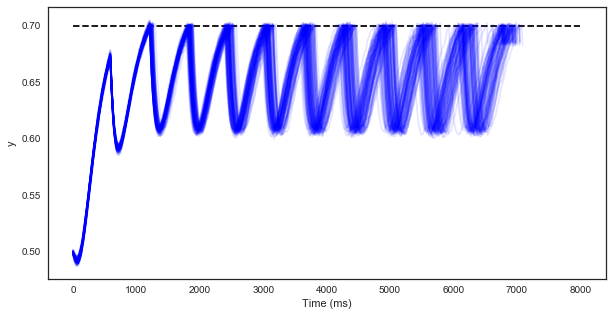

In [33]:
ulst, vlst, ylst, Ilst, siglst, ylst2 = simulate_trial_multiple(ntrials=100, nstages=3, duration=600, 
                                                                sigma=0.01, K=2, initI=0.771,
                                                               nprod=10)

plt.figure(figsize=(10, 5))
a = remove_nan_transpose(ylst)
for i in range(len(a)):
    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.xlabel('Time (ms)')
plt.ylabel('y')
plt.hlines(0.7, 0, 8000, linestyles='--')